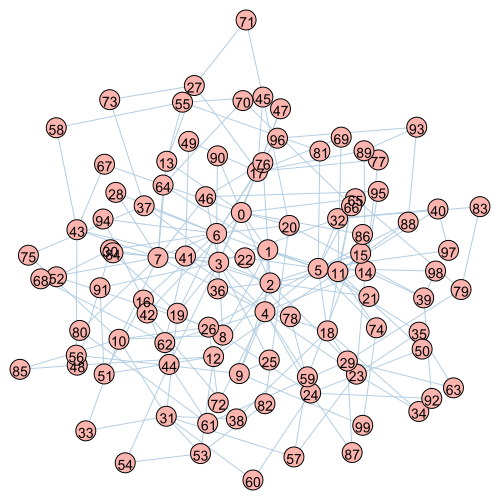

In [8]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a tree network using igraph method
#G = Graph.Erdos_Renyi(n = 100, p = 0.1, directed = False)
G = Graph.Barabasi(n = 100, m = 2, directed = False)
#G = Graph.Tree(100,2)



G.vs["name"] = [str(i) for i in range(len(G.vs))]

#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})


# Plotting with custom colors and saving to a file
p_style = {"bbox": (500, 500), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
output_path = "C:/Users/abbau/Downloads/ER400.pdf"
# Specify the path and filename here
plot(G, target=output_path, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [9]:
# Parameters
# Transmission rate
beta = 0.1
# Recovery rate
gamma = 0.1
#Time 
T = 10
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 0.4

In [10]:
def SIR_MC(g, p0, beta, gamma, T, num_simulations):
    nodes = p0['node'].tolist()
    init_probs = p0['prob'].tolist()
    start = time.time()

    # Extract nodes with a specific initial infection probability
    unique_prob = [prob for prob in set(init_probs) if prob != 0][0]
    initialized_nodes = p0[p0['prob'] == unique_prob]['node'].tolist()


    # Create neighbors dictionary
    neighbors = {node: set() for node in nodes}
    for row in g.itertuples():
        neighbors[row.source].add(row.target)
        neighbors[row.target].add(row.source)

    # Results arrays
    avg_mrg_s = np.zeros((T, len(nodes)))
    avg_mrg_i = np.zeros((T, len(nodes)))
    avg_mrg_r = np.zeros((T, len(nodes)))

    for simulation in range(num_simulations):
        # Initialize states as susceptible
        state = {node: 'S' for node in nodes}
        
        
        # Randomly infect other nodes based on probabilities
        for node, init_prob in zip(nodes, init_probs):
            if node in initialized_nodes and np.random.random() < init_prob:
                state[node] = 'I'

        # Count initial states before the simulation starts
        for i, node in enumerate(nodes):
            avg_mrg_s[0, i] += state[node] == 'S'
            avg_mrg_i[0, i] += state[node] == 'I'
            avg_mrg_r[0, i] += state[node] == 'R'

        # Simulation loop
        for t in range(1, T):
            new_state = state.copy()
            for i in nodes:
                if state[i] == 'I':
                    # Infect susceptible neighbors
                    for neighbor in neighbors[i]:
                        if state[neighbor] == 'S' and np.random.random() < beta:
                            new_state[neighbor] = 'I'
                    # Recovery
                    if np.random.random() < gamma:
                        new_state[i] = 'R'
            state = new_state

            # Count states at each time step
            for i, node in enumerate(nodes):
                avg_mrg_s[t, i] += state[node] == 'S'
                avg_mrg_i[t, i] += state[node] == 'I'
                avg_mrg_r[t, i] += state[node] == 'R'
                
            
                
    # Average the results across simulations
    avg_mrg_s /= num_simulations
    avg_mrg_i /= num_simulations
    avg_mrg_r /= num_simulations
    
   
    #print("SIRMC Runtime:   " + str(round(time.time() - start, 2)) + " seconds")

    return avg_mrg_s, avg_mrg_i, avg_mrg_r

In [35]:
# observed_s, observed_i, observed_r = SIR_MC(g, p0, beta, gamma, T, 10000)

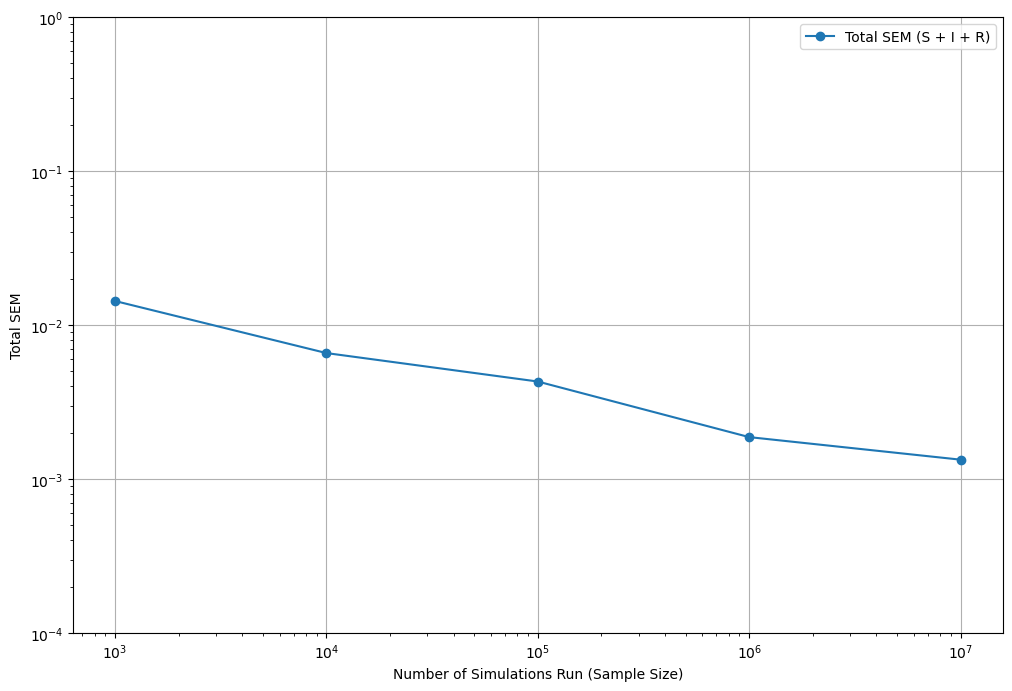

In [11]:


def run_sir_with_sems(g, p0, beta, gamma, T):
    sim_counts = [1000, 10000, 100000, 1000000, 10000000] 
    SEMs = {'s': [], 'i': [], 'r': []}

    for count in sim_counts:
        observed_s, observed_i, observed_r = SIR_MC(g, p0, beta, gamma, T, count)
        SEM_s = np.std(observed_s, axis=1) / np.sqrt(count)
        SEM_i = np.std(observed_i, axis=1) / np.sqrt(count)
        SEM_r = np.std(observed_r, axis=1) / np.sqrt(count)

        # Collect the last time point SEMs for each count
        SEMs['s'].append(SEM_s[-1])
        SEMs['i'].append(SEM_i[-1])
        SEMs['r'].append(SEM_r[-1])

    # Calculate the sum of SEMs for the last time point
    SEM_total = [SEMs['s'][i] + SEMs['i'][i] + SEMs['r'][i] for i in range(len(sim_counts))]
    
    # Ensure SEM_total has no zero values
    SEM_total = [max(val, 1e-10) for val in SEM_total]

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(sim_counts, SEM_total, label='Total SEM (S + I + R)', marker='o')
    plt.xlabel('Number of Simulations Run (Sample Size)')
    plt.ylabel('Total SEM')
    plt.xscale('log')
    plt.yscale('log')

    # Adjust y-axis limits and add more y-ticks for better visualization
    plt.ylim(min(SEM_total) / 10, max(SEM_total) * 10)
    yticks = [10**i for i in range(int(np.floor(np.log10(min(SEM_total)))) - 1, int(np.ceil(np.log10(max(SEM_total)))) + 2)]
    plt.yticks(yticks)
    
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/abbau/Downloads/BASEM.pdf', format='pdf', bbox_inches="tight")
    plt.show()

# Example of how to call the function:
run_sir_with_sems(g, p0, beta, gamma, T)
